In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw07.ipynb")

# Homework 7: Probability and Estimators
## Due Date: Thursday, July 27th, 11:59 PM PDT

You must submit this assignment to Gradescope by the on-time deadline, Thursday, July 27th, 11:59pm. Please read the syllabus for the grace period policy. No late
submissions beyond the grace period will be accepted. **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to reach out to staff for support if you encounter difficulties with submission. While course staff is happy to help guide you with submitting your assignment ahead of the deadline, we will not respond to last-minute requests for assistance (TAs need to sleep, after all!).

Please read the instructions carefully to submit your work to both the coding and written portals of Gradescope.


## Content Warning

This assignment includes an analysis of daily COVID-19 cases by U.S. county through 2021. If you feel uncomfortable with this topic, **please contact your GSI or the instructors.**



## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*

## Introduction

In this homework, we will investigate a dataset that contains information about COVID-19 cases in the United States, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this homework assignment, you will demonstrate your experience with:
* Bootstrap sampling
* Bias-variance tradeoff and decomposition
* Multicollinearity in features

## Grading
Grading is broken down into autograded answers and free response. 

For autograded answers, the results of your code are compared to provided and/or hidden tests.

For free response, readers will evaluate how well you answered the question and/or fulfilled the requirements of the question. 

### Score breakdown

Question | Manual | Points
--- |---| ---
1a| No | 3
1b| No | 1
1c| Yes | 3
1d| Yes | 3
2a| No | 4
2b| Yes |3
2c| Yes | 1
3a| No | 2
3b| No | 4
3c| No | 2
3d| Yes | 3
4a| No | 3
4b| Yes | 3
4c| No | 2
4d| Yes | 2
Total | 7 | 39

In [2]:
# Run this cell to set up your notebook
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown

import scipy.stats

import warnings
warnings.filterwarnings("ignore")

<br/><br/><br/>

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Exploratory Data Analysis

Let's perform some initial exploratory data analysis to examine and visualize potential trends in a COVID-19 dataset.

In [3]:
# Run this cell to load the data, no further action needed.
covid_data = pd.read_csv('data/covid_data.csv')
covid_data.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,84001001,US,USA,840,1001,Autauga,Alabama,US,32.539527,-86.644082,...,55533,55769,56130,56145,1001,0.053,0.074,0.134,0.295,0.444
1,84001003,US,USA,840,1003,Baldwin,Alabama,US,30.727750,-87.722071,...,218071,223565,227989,229287,1003,0.083,0.059,0.098,0.323,0.436
2,84001005,US,USA,840,1005,Barbour,Alabama,US,31.868263,-85.387129,...,24887,24657,24652,24589,1005,0.067,0.121,0.120,0.201,0.491
3,84001007,US,USA,840,1007,Bibb,Alabama,US,32.996421,-87.125115,...,22300,22313,22199,22136,1007,0.020,0.034,0.096,0.278,0.572
4,84001009,US,USA,840,1009,Blount,Alabama,US,33.982109,-86.567906,...,57770,57840,57932,57879,1009,0.053,0.114,0.180,0.194,0.459


The data are at county granularity; each row corresponds to COVID-19 data from one U.S. county. Here are some highlights and data sources:

* The first few columns encode county and state data; for example, check out the [Federal Information Processing System (FIPS)](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) numeric encoding for U.S. counties.
* The next 600 columns record daily COVID-19 cases in the county for the date range 1/22/2020 to 9/12/2021. COVID-19 case data are from Center for Systems Sciences and Engineering (CSSE) at Johns Hopkins University [GitHub](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv).
* The next few columns include county populations from [U.S. census data](https://data.census.gov/), the latest of which is 2020.
* The last 5 columns record mask usage survey data on a 5-point scale from `NEVER` to `ALWAYS`. Data are collected in July 2020 from the New York Times [GitHub](https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv). Each column represents the proportion of population in that county who never/rarely/sometimes/frequently/always wear masks. Note, for a particular row, the numbers in those five columns sum up to $1$.

We can use `covid_data.describe()` to see various statistics about the numerical features of the provided COVID-19 data. Do any particular statistics stand out to you? Which might be useful when modeling?

**Note:** This isn't a question (i.e. it's worth no points); This is just food for thought as you start to explore the dataset.

In [4]:
# Run this cell to load the data see see statistics of the covid_data
covid_data.describe()

,UID,code3,FIPS,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
count,3.141000e+03,3141.0,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,...,3.141000e+03,3.141000e+03,3.141000e+03,3.141000e+03,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000
mean,8.403039e+07,840.0,30392.602674,38.448156,-92.272006,0.000318,0.000318,0.000637,0.000637,0.001592,...,1.040525e+05,1.045274e+05,1.048677e+05,1.048949e+05,30392.602674,0.079952,0.082929,0.121340,0.207728,0.508044
std,1.515661e+04,0.0,15156.613190,5.292540,12.909318,0.017843,0.017843,0.025230,0.025230,0.039873,...,3.326200e+05,3.332156e+05,3.335848e+05,3.333719e+05,15156.613190,0.058543,0.055469,0.058007,0.063581,0.152190
min,8.400100e+07,840.0,1001.000000,19.601212,-174.159600,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.700000e+01,8.700000e+01,9.000000e+01,8.700000e+01,1001.000000,0.000000,0.000000,0.001000,0.029000,0.115000
25%,8.401818e+07,840.0,18179.000000,34.693167,-98.218207,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.096300e+04,1.093600e+04,1.091900e+04,1.092100e+04,18179.000000,0.034000,0.040000,0.079000,0.164000,0.393000
50%,8.402918e+07,840.0,29177.000000,38.373019,-90.396561,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.583700e+04,2.573500e+04,2.570100e+04,2.565800e+04,29177.000000,0.068000,0.073000,0.115000,0.204000,0.497000
75%,8.404508e+07,840.0,45081.000000,41.802830,-83.436796,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.813600e+04,6.828200e+04,6.822000e+04,6.824100e+04,45081.000000,0.113000,0.115000,0.156000,0.247000,0.613000
max,8.405604e+07,840.0,56045.000000,69.314792,-67.628135,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.006153e+07,1.001160e+07,9.968969e+06,9.943046e+06,56045.000000,0.432000,0.384000,0.422000,0.549000,0.889000


<br><br>

---

### Question 1a

In this homework, we will use linear regression to predict **the number of COVID-19 cases  per capita on September 12th, 2021**. Define a column `'9/12/2021_cpc'` in `covid_data` corresponding to the number of cases per capita on September 12th, 2021. 

Note that we will **always** use the `'POPESTIMATE2020'` as the population of each county.

*Hint*: The number of cases per capita should be the total number of cases in a county divided by the population of the county.


In [5]:
covid_data['9/12/2021_cpc'] = covid_data['9/12/21']/covid_data['POPESTIMATE2020']

In [6]:
grader.check("q1a")

q1a results: All test cases passed!

<br><br>

---

### Question 1b

Assign `mask_data` that has six columns from the original `covid_data` table: the five mask usage columns described earlier and the `9/12/2021_cpc` column.

**Note**: You should make a **copy** of these columns using `df.copy()` ([link](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html)).

In [7]:
mask_data = covid_data[['NEVER', 'RARELY','SOMETIMES','FREQUENTLY','ALWAYS','9/12/2021_cpc']].copy()
mask_data

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,9/12/2021_cpc
0,0.053,0.074,0.134,0.295,0.444,0.165411
1,0.083,0.059,0.098,0.323,0.436,0.152429
2,0.067,0.121,0.120,0.201,0.491,0.134003
3,0.020,0.034,0.096,0.278,0.572,0.171440
4,0.053,0.114,0.180,0.194,0.459,0.158538
...,...,...,...,...,...,...
3136,0.061,0.295,0.230,0.146,0.268,0.143205
3137,0.095,0.157,0.160,0.247,0.340,0.196238
3138,0.098,0.278,0.154,0.207,0.264,0.158496
3139,0.204,0.155,0.069,0.285,0.287,0.144330


In [8]:
grader.check("q1b")

q1b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 1c

Our goal is to use county-wise mask usage data to predict the number of COVID-19 cases per capita on September 12th, 2021 (i.e., the column `9/12/2021_cpc`). But before modeling, let's do some EDA to explore the multicollinearality in these features, and then we will revisit this question in part 4. 

Create a visualization that shows the pairwise correlation between each combination of columns in `mask_data`. For 2-D visualizations, consider Seaborn's [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html). Remember to add a title to your plot.

**Hint**: You should be plotting 36 values corresponding to the [pairwise correlations](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) of the six columns in `mask_data`.


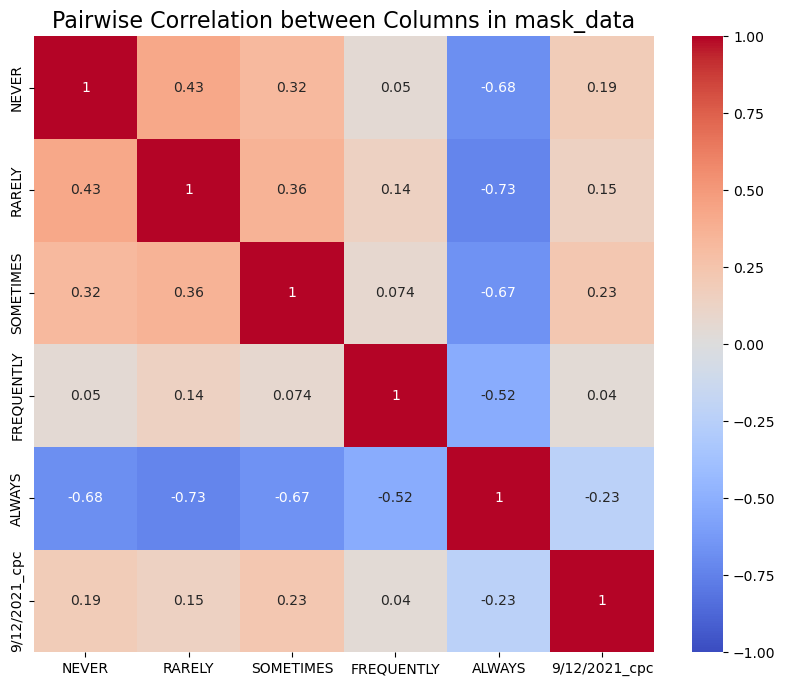

In [9]:
correlation_matrix = mask_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Pairwise Correlation between Columns in mask_data", fontsize=16)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 1d

(1) Describe the trends and takeaways visible in the visualization of pairwise correlations you plotted in Question 1c. Specifically, how does the correlation between pairs of features (i.e. mask usage) look like? How does the correlation between mask usage and cases per capita look like?

(2) If we are going to build a linear regression model (with an intercept term) using all five mask usage columns as features, then what problem will we encounter?

(1) The overall correlation between the features are weak. However, Always of wearing mask has a generally high negative correlation with other featurs, with a value less than -0.6. This suggests that people who report higher mask usage tend to report lower mask avoidance and vice versa. It's also noticable that there are few positive kind of high correlation between features(i.e. Rarely and Never has a correlation of 0.43). From the graph, the cases per capita generally has a low correlation with other features, with a maximum of 0.23 correlation.
(2) When building a linear regression model using all five mask usage columns as features, we will encounter multicollinearity. In this case, the high negative correlation between the mask usage columns can lead to a problem where the model cannot distinguish the individual effects of each mask usage category on the target variable (cases per capita). As a result, the model may not provide meaningful or interpretable coefficient estimates for the mask usage features, making it difficult to draw reliable conclusions from the model.

<!-- END QUESTION -->

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Creating a Preliminary COVID-19 Model

This question will guide you through creating a linear regression model that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this model in the next two questions.


<br><br>

---

### Question 2a

Despite the problems we see previously, let's train a linear regression model with an intercept term, using Scikit-learn, to predict the number of COVID-19 cases per capita for September 12, 2021 using county-wise mask usage data from `mask_data`. Use `train_test_split` to evaluate your model's RMSE on a held-out test set with 33% of the COVID-19 data; call the resulting splits `X_train`, `X_test`, `y_train`, and `y_test`.

To pass the autograder, make sure to set the parameter `random_state` to 42 in your call to `train_test_split` to generate a reproducible data split ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).



In [10]:
# Create train/test sets
X = mask_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
y = mask_data['9/12/2021_cpc']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)

# Fit the linear model and make predictions (you will need multiple lines)
model = lm.LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Compute RMSE on train and test sets
train_rmse_cpc = np.sqrt(np.mean((y_train-y_train_pred)**2))
test_rmse_cpc = np.sqrt(np.mean((y_test-y_test_pred)**2))


train_rmse_cpc, test_rmse_cpc

(0.03552339478226883, 0.037954861477287)

In [11]:
grader.check("q2a")

q2a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 2b

To visualize the model performance from part (a), let's make the following two visualizations: 

(1) The predicted values vs. observed values on the test set,

(2) The residuals plot. (Note: in multiple linear regression, the residual plot has the residuals plotted against the predicted values) 

**Note:**
* We've used `plt.subplot` ([documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)) so that you can view both visualizations side-by-side. For example, `plt.subplot(121)` sets the plottable area to the first column of a 1x2 plot grid; you can then call Matplotlib and Seaborn functions to plot that area, before the next `plt.subplot(122)` area is set.
* Remember to add a guiding line to both plot where $\hat{y} = y$, i.e., where the residual is 0.
* Please add descriptive titles and axis labels for your plots!

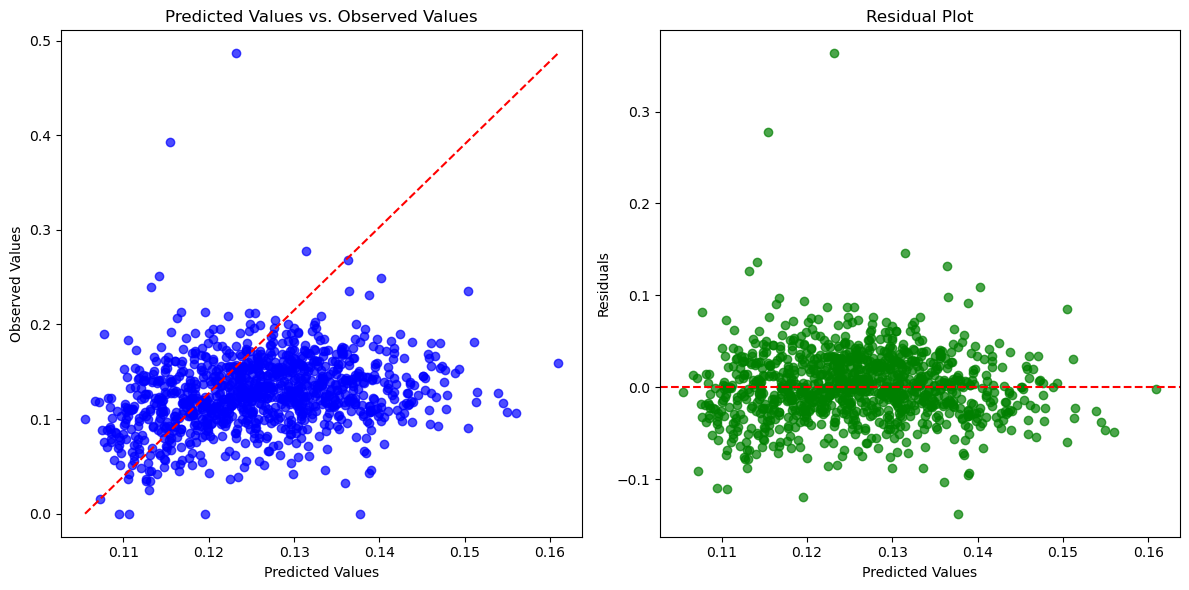

In [12]:
plt.figure(figsize=(12,6))      # do not change this line
plt.subplot(121)                # do not change this line
# (1) predictions vs. observations
y_test_pred = model.predict(X_test)
plt.scatter(y_test_pred, y_test, alpha=0.7, color='blue')
plt.plot([min(y_test_pred), max(y_test_pred)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.title('Predicted Values vs. Observed Values')


plt.subplot(122)               # do not change this line
# (2) residual plot
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()             # do not change this line

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 2c

Describe what the plots in part (b) indicate about this linear model. In particular, are the predictions good?


The scatter plot of Observed Values vs. Predicted Values indicates that the model's predictions are not perfectly aligned with the actual observed values. Ideally, the data points should cluster tightly around the line y=ŷ (where y is the observed value and ŷ is the predicted value). However, we can see that the data points are scattered around the reference line (red dashed line) with some degree of variation, suggesting that the model's predictions are not precise.
Also, in a well-performing linear regression model, the residuals should be randomly scattered around the x-axis with no specific pattern. However, in this case, we can observe a clear pattern in the residuals. The residuals seem to center around zero at approximately the range (0.12, 0.13) on the y-axis. This indicates that the model is capturing some patterns in the data but is not capturing all the variability. The residuals have more significant variations away from the center point, indicating that the model's predictions deviate more from the actual values for some data points.

<!-- END QUESTION -->

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Performing Multicollinearity Analysis

This question will guide you through performing an analysis that can reveal potential multicollinearity in our features, which is not ideal. In particular, we will use bootstrap to get $95\%$ confidence intervals on the fitted parameters. Here's a reminder of the outline of boostrapping:

1. (3a) Assume the sample is a representative sample, we can simulate different samples by resampling from the original sample.
2. (3b) Calculate statistic(s) for each resample to simulate different potential result. Statistic can be a mean (Lab 9), correlation (Lab 9), coefficients of a linear model (Q3 below), and any function of the sample data.
3. (3c) Use the distribution of the above statistics calculated on each of the resample to construct confidence interval.
4. (3d) Use the result of confidence interval to make inference of the population.

<br><br>

---

### Question 3a

Fill in the blanks below to implement the `bootstrap_sample` function, that returns $k$ randomly drawn samples from a dataset `data` of size $n$ with replacement, each of size $n$ (i.e. same size as the dataset). In other words, the returned object should be a Python list `samples` containing $k$ Pandas DataFrames, each of which have $n$ rows.

**Hint**: You may find `df.sample` helpful, see [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html). This is very similar to Lab 8.


In [13]:
def bootstrap_sample(data, k):
    """
    Performs bootstrap sampling on data to obtain k samples of size n.
    
    Arguments:
        data - Dataset contained as a Pandas DataFrame 
        k - Number of randomly drawn samples
    
    Returns:
        samples - List containing k Pandas DataFrames of size n each
                  corresponding to each sample  
    """
    samples = []
    n=len(data)
    for _ in range(k):
        x = data.sample(n=n, replace=True)
        samples.append(x)
    return samples

# Print out the first dataframe only
bootstrap_sample(mask_data, 1)[0]

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,9/12/2021_cpc
792,0.224,0.073,0.194,0.187,0.322,0.104543
726,0.094,0.084,0.205,0.258,0.359,0.141635
1565,0.183,0.109,0.103,0.189,0.416,0.150662
132,0.066,0.027,0.077,0.403,0.426,0.144108
836,0.032,0.096,0.229,0.232,0.411,0.124915
...,...,...,...,...,...,...
360,0.027,0.018,0.066,0.169,0.719,0.116085
200,0.075,0.016,0.049,0.094,0.766,0.180959
2175,0.173,0.175,0.213,0.135,0.303,0.143541
2059,0.042,0.052,0.084,0.213,0.609,0.105739


In [14]:
grader.check("q3a")

q3a results: All test cases passed!

<br><br>

---

### Question 3b

Using the function from the previous part, let's do the following:

1. Generate 1000 bootstrapped samples from the original `mask_data` dataframe. 
2.  For each of the 1000 bootstrapped samples, use `sklearn` to fit a linear regression model (with an intercept term) same as in Question 2, where mask usage are the features and `9/12/2021_cpc` is the response. You should fit 1000 models in total. 
3. Store each of the 1000 trained models in the Python list `models`.

**Hint:**
* You *should not* create any validation or testing sets in this subpart, your model should fit to the entire resampled dataframe.
* `LinearRegression` is an object type, to store a new model you must create a new instance first!

In [15]:
np.random.seed(42)

datasets = bootstrap_sample(mask_data, 1000)
models = []
for i in range(1000):
    X = datasets[i][['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
    y = datasets[i]['9/12/2021_cpc']
    
    
    model = lm.LinearRegression()
    model.fit(X, y)
    
    # Append the trained model to the list of models
    models.append(model)


# Datasets take up a lot of memory, so we should remove them!
del datasets

In [16]:
grader.check("q3b")

q3b results: All test cases passed!

<br><br>

---

### Question 3c

Fill in the blanks below in the `confidence_interval` function to generate a $95\%$ confidence interval for each of our parameters $\theta_i$, including the intercept term $\theta_0$. All of the helper code to extract coefficients from our trained models has been implemented for you already.

**Hint**: 
- For a refresh on confidence intervals, refer to this link from the [Data 8 textbook](https://inferentialthinking.com/chapters/13/3/Confidence_Intervals.html). 
- Pay close attention to how the arrays used below are formated. What does each row represent? What does each column represent? To get the $i$th column from a 2D-array, you can use `2D_array[:, i]`.


In [17]:
def extract_coefs(models, include_intercept = True):
    """
    NOTE: This function has already been implemented. You do not need to modify this!
    
    Extracts coefficients of all the linear regression models in MODELS, and returns
    it as a NumPy array with one model's coefficients as each row.
    
    Arguments:
        models - Contains k sklearn LinearRegression models, each with p + 1 coefficients
        include_intercept - Whether to include intercept in returned coefficients
    
    Returns:
        coef_array - Coefficients of all k models, each with p + 1 coefficients (if intercept
                     enabled, otherwise p). Returned object is k x (p + 1) NumPy array.
    """
    coef_array = np.zeros(shape = (len(models), len(models[0].coef_) + 1))
    for i, m in enumerate(models):
        coef_array[i, 0] = m.intercept_
        coef_array[i, 1:] = m.coef_
    if include_intercept:
        return coef_array 
    return coef_array[:, 1:]

def confidence_interval(coefs):
    """
    Calculates confidence intervals for each theta_i based on coefficients of 
    bootstrapped models. Returns output as a list of confidence intervals.
    
    Arguments:
        coefs - Output of extract_coefs, a k x (p + 1) or k x p NumPy array containing
                coefficients of bootstrapped models
    
    Returns:
        cis - Confidence intervals of each parameter theta_i in the form of a 
              list like this: [(0.5, 0.75), (0.2, 0.4), ...]
    """
    cis = []
    
    # FILL IN CODE BELOW
    for i in range(coefs.shape[1]):
        theta_i_values = coefs[:, i]
        theta_i_lower_ci, theta_i_upper_ci = np.percentile(theta_i_values, 2.5), np.percentile(theta_i_values, 97.5)
        cis.append((theta_i_lower_ci, theta_i_upper_ci))
    
    return cis


# Compute confidence intervals
model_coefs = extract_coefs(models)
cis = confidence_interval(model_coefs)

# Pretty print in a table
display(Markdown('#### Confidence Intervals:'))
md_list = ["|parameter|lower|upper|",
           "----|----|----|"]
md_list += [fr"|$\theta_{i}$|{lci}|{uci}|" for i, (lci, uci) in enumerate(cis)]
display(Markdown('\n'.join(md_list)))

#### Confidence Intervals:

|parameter|lower|upper|
----|----|----|
|$\theta_0$|-2.6200726729046937|1.2507871842262086|
|$\theta_1$|-1.0896828874135185|2.798332585238362|
|$\theta_2$|-1.1461331540818134|2.744519025435908|
|$\theta_3$|-1.018294369222972|2.8436420433762395|
|$\theta_4$|-1.1582158941591825|2.7329392573407363|
|$\theta_5$|-1.1477854499077667|2.7195109052029274|

In [18]:
grader.check("q3c")

q3c results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 3d

Interpret the confidence intervals above for each of the $\theta_i$, where $\theta_0$ is the intercept term and the remaining $\theta_i$'s are parameters corresponding to mask usage features. What does this indicate about our data and our model?

Describe a reason why this could be happening.

**Hint**: Take a look at the design matrix, heatmap, and response from Question 1!


The confidence intervals for each parameter, including the intercept term (theta_0) and the remaining parameters corresponding to mask usage features, indicate the uncertainty in the estimates of these parameters based on the bootstrapped models. The intervals represent a range of values  we are onfident that the true population parameter lies. The confidence intervals cover the value 0 for all features (including theta_0). This indicates that our data and model are not providing strong evidence that any of the mask usage features have a statistically significant impact on the response variable (9/12/2021_cpc). 
As observed in the heatmap from Question 1, some of the mask usage features may be highly correlated with each other. This multicollinearity can lead to unstable and less interpretable estimates of the coefficients.

<!-- END QUESTION -->

<br/><br/><br/>

<hr style="border: 1px solid #fdb515;" />

## Question 4: Performing Bias-Variance Analysis

This question will guide you through performing an analysis that can estimate the bias and variance of our models, which can be helpful in modeling.

Recall that the **model variance** on a data point $\vec{x_k}$ is simply the variance of our predictions on that sample point $\vec{x_k}$. 

$$\text{model variance} = \mathrm{Var}(\hat{Y}(\vec{x_k})) = \mathrm{Var}(\vec{x_k}^T\hat{\theta})$$

Since we are using OLS, we can also rewrite our model as $\hat{Y}(\vec{x_k}) = \vec{x_k}^T\hat{\theta} = \hat{\theta_0}\times 1 + \hat{\theta_1}x_1 + ... + \hat{\theta_p}x_p$. To estimate the model variance, we can sample a particular data point $(\vec{x_k}, y_k)$, and calculate the variance of the predictions using different fitted model in `models`. Note that the varaince is taken acorss different models, $\vec{x_k}$ are pre-selected and fixed. 

Also recall that **model risk** for this point is the same as mean square error over all possible fitted models:

$$
\text{model risk} = \mathbb{E}\left[\left(y_k - \hat{Y}(\vec{x_k}) \right)^2\right] \approx \frac{1}{\# \text{ of bootstrap}}\sum_{j=1}^{\# \text{ of bootstrap}} (y_k - \hat{Y}_j(\vec{x_k}))^2 = MSE(\vec{x_k})
$$

Where the subscript is used to denote different models. Here, we are considering a particular observation of the random response variable $y_k$. Therefore model risk is an expectation over the estimate $\hat{\theta}_j$, coefficients corresponding to different models. $\hat{\theta}_j$ itself is a random variable, because it was derived by fitting to different random resamples. We can also find the ratio of model variance to model risk. You can interpret this ratio as the proportion of the expected square error on the data point "captured" or "explained" by the model variance: 

$$
\frac{\text{model variance}}{\text{model risk}}=\frac{\mathrm{Var}(\hat{Y}(\vec{x_k}))}{\mathbb{E}\left[\left(y_k - \hat{Y}(\vec{x_k}) \right)^2\right]}
$$

<br><br>

---

### Question 4a

Let's use the 100th data point $(\vec{x_{100}}, y_{100})$, i.e. k = 100 to find these quantities!

Complete the function `simulate` that takes in a data point `xk`, `yk` and returns `model_risk`, `model_var`, and `ratio`, ratio of model variance to model risk.

Here is a suggested format but you do not need to follow the skeleton code:
* Assign `predictions` to a length 1000 vector where each element is the prediction on `xk` using a model in `models`. Note that sklearn's `.predict` return an array, but we only need a scaler prediction! Try to print out a prediction and ajust your code if needed.
* Use `predictions` to compute estimated `model_risk`.
* Use `predictions` to compute estimated `model_var`.
* Use `model_risk` and `model_var` to compute the `ratio`, ratio of model variance to model risk.

**Hint**: Use list comprehension for creating your predictions to save overhead of using multiple appends.

In [19]:
def simulate(xk, yk, models):
    predictions = [model.predict([xk])[0] for model in models]
    model_risk = np.mean((yk - predictions) ** 2)
    model_var = np.var(predictions)
    ratio = model_var / model_risk
    return model_risk, model_var, ratio

x_100 = mask_data[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']].iloc[100]
y_100 = mask_data['9/12/2021_cpc'].iloc[100]
model_risk, model_var, ratio = simulate(x_100, y_100, models)
model_risk, model_var, ratio

(0.0020706473192105674, 2.726872001409053e-06, 0.0013169176499108844)

In [20]:
grader.check("q4a")

q4a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 4b

Comment on the ratio `ratio`, which is the proportion of the expected square error on the data point captured by the model variance. Is the model variance the dominant term in the bias-variance decomposition? If not, what term(s) dominate the bias-variance decomposition?

**Note**: The Bias-Variance decomposition from lecture:

$$
\text{model risk} = \sigma^2 + (\text{model bias})^2 + \text{model variance}
$$

where $\sigma^2$ is the observation variance, or "irreducible error".


The rratio is approximately 0.0013169, which means that the model variance captures only about 0.1317% of the expected square error on the data point. In this case, the model variance is significantly smaller compared to the model risk, indicating that the model variance is not the dominant term in the bias-variance decomposition. Since the model variance is very small compared to the model risk, indicating that the model is not overfitting, and model risk can be decomposed into observation variiance, model bias, and model variance. We are not able to see if observation variance or model bias is the dominate decomposition.

<!-- END QUESTION -->

<br><br>

---

### Question 4c

Now let's calculate the average variance and average mean square error across 250 randomly sampled $(x_i, y_i)$ points. In other words, estimate the following quantities across all $x_i$ and $y_i$ in `X_sample` and `y_sample`:

$$
\frac{1}{250} \sum_{k=1}^{250} \mathrm{Var}\left(\hat{Y}(\vec{x_k})\right)
$$

and

$$
\frac{1}{250} \sum_{k=1}^{250} \mathbb{E}\left[ (y_k - \hat{Y}(\vec{x_k}))^2 \right]
$$

**Hint:** Call `simulate` from 4a.


In [26]:
np.random.seed(42)

X_sample = X.sample(250)         # Generate 250 x_i
y_sample = y.loc[X_sample.index] # ...and select the corresponding y_i

var, mse = [], []
for i in range(250):
    xk, yk = X_sample.iloc[i], y_sample.iloc[i]
    model_risk, model_var, _ = simulate(xk, yk, models)
    var.append(model_var)
    mse.append(model_risk)

avg_var, avg_mse = np.mean(var), np.mean(mse)
avg_var, avg_mse

(2.8248352750171086e-06, 0.0016658308894561503)

In [22]:
grader.check("q4c")

q4c results: All test cases passed!

<!-- BEGIN QUESTION -->

<br><br>

---

### Question 4d

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above.

Assume that the standard bias-variance decomposition used in lecture can be applied here.


We can use feature engineering. We can analyze the correlation between the features and the target variable to identify redundant or irrelevant features. Removing or transforming such features can help reduce the model variance and improve the model's ability to generalize to new dat unseen data.








<!-- END QUESTION -->

<br><br>


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Homework 7!

Here are some cats :) Can you find their names? There are two ways you can find it on JupyterLab.

<img src="Pandas.jpg" width="370px"/> <img src="Patches.jpg" width="200px" /> <img src="Pishi.jpg" width="208px" />


Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. **You are responsible for both the coding portion (the zip from Homework 7) and the written portion (the PDF with from Homework 7) to their respective Gradescope portals.** The coding proportion should be submitted to Homework 7 Coding as a single zip file, and the written portion should be submitted to Homework 7 Written as a single pdf file. When submitting the written portion, please ensure you select pages appropriately and check all plots appear. 

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> PDF`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit those. Either way, **you are responsible for ensuring your submission follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**


In [23]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("hw07.ipynb", filtering=True, pagebreaks=True)
if(path.exists('hw07.pdf')):
    display(HTML("Download your PDF <a href='hw07.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [24]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...

Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q2a results: All test cases passed!

    q3a results: All test cases passed!

    q3b results: All test cases passed!

    q3c results: All test cases passed!

    q4a results: All test cases passed!

    q4c results: All test cases passed!
